# **Irene Dovichi** 
## Midterm 3 - Assignment 3
Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Loading

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

In [3]:
# Keep only Date, Time, C6H6, and PT08.* columns
df = df[['Date', 'Time', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
df.head()

,Date,Time,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,10/03/2004,18.00.00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,10/03/2004,19.00.00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,10/03/2004,20.00.00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,10/03/2004,21.00.00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,10/03/2004,22.00.00,6.5,1272.0,836.0,1205.0,1490.0,1110.0


In [4]:
df.isna().sum()

Date             114
Time             114
C6H6(GT)         480
PT08.S1(CO)      480
PT08.S2(NMHC)    480
PT08.S3(NOx)     480
PT08.S4(NO2)     480
PT08.S5(O3)      480
dtype: int64

In [5]:
# Drop rows with nan values and reset index
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

Date             0
Time             0
C6H6(GT)         0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
dtype: int64

In [6]:
df.shape

(8991, 8)

In [7]:
# Combine Date and Time columns into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df.insert(0, 'DateTime', df.pop('DateTime'))

# We notice that df is ordered by DateTime since the min is the first row and the max is the last row
df['DateTime'].min(), df['DateTime'].max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2005-04-04 14:00:00'))

## Model Selection
I will start with LSTM, then GRU and (maybe) Clockwork RNN

In [8]:
#TODO: decidere che tecniche usare (dropout, minibatch,truncated backpropagation, ecc) e che architetture provare
#TODO: confrontare LSTM, GRU e Clockwork RNN (provare almeno 1 modello per ogni tipo)

### Train/Test Split

In [23]:
# TODO: forse dovrei prendere come train fino a fine 2004 e come test da inizio 2005 in poi? E validation?

In [24]:
# see what is the first instance of 2005
df[df['DateTime'].dt.year == 2005].head()

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
6882,2005-01-01 00:00:00,4.2,1046.0,724.0,848.0,898.0,1201.0
6883,2005-01-01 01:00:00,8.8,1275.0,930.0,649.0,1024.0,1617.0
6884,2005-01-01 02:00:00,7.5,1173.0,878.0,738.0,1002.0,1355.0
6885,2005-01-01 03:00:00,7.6,1163.0,881.0,748.0,1001.0,1296.0
6886,2005-01-01 04:00:00,5.6,1054.0,791.0,830.0,967.0,1131.0


In [27]:
# 6882 : len(df) = x : 100
x = 6882 * 100 // len(df)
print(f'{x}%')

76%


In [29]:
# TODO: potrei prendere come train fino a fine 2004, cioe fino all'istanza 6881 (train: 76% of df) e poi dividere il restante df tra val e test

In [30]:
len(df) - 6882

2109

In [31]:
#------------------------------------------------------------

In [9]:
# calculate 80% of length of df
train_size = int(len(df) * 0.8)
train_size

7192

In [10]:
# see instances 7190 to 7195
df.iloc[7189:7195]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
7189,2005-01-15 23:00:00,11.1,1231.0,1017.0,655.0,1207.0,1414.0
7190,2005-01-16 00:00:00,13.6,1289.0,1104.0,623.0,1257.0,1499.0
7191,2005-01-16 01:00:00,9.8,1166.0,970.0,705.0,1136.0,1306.0
7192,2005-01-16 02:00:00,7.6,1062.0,884.0,748.0,1062.0,1172.0
7193,2005-01-16 03:00:00,6.0,1028.0,813.0,794.0,1019.0,1076.0
7194,2005-01-16 04:00:00,5.9,1003.0,807.0,819.0,1021.0,1005.0


We can notice that choosing instance 7189 as the last for the train will give approximately the 80% of the data as train data, and we avoid to stop in the middle of measurements for a specific day

In [11]:
train_start_date = df['DateTime'].iloc[0]
train_end_date = df['DateTime'].iloc[7189]

test_start_date = df['DateTime'].iloc[7190]
test_end_date = df['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
test = df[(df['DateTime'] >= test_start_date) & (df['DateTime'] <= test_end_date)]

In [12]:
# calculate 80% of length of train
train_size = int(len(train) * 0.8)
train_size

5752

In [13]:
train.iloc[5752:5765]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
5752,2004-11-11 14:00:00,18.0,1252.0,1240.0,564.0,1614.0,1277.0
5753,2004-11-11 15:00:00,14.3,1186.0,1125.0,617.0,1493.0,1171.0
5754,2004-11-11 16:00:00,13.7,1172.0,1107.0,629.0,1449.0,1106.0
5755,2004-11-11 17:00:00,11.2,1109.0,1021.0,689.0,1361.0,1036.0
5756,2004-11-11 18:00:00,16.5,1201.0,1196.0,597.0,1546.0,1196.0
5757,2004-11-11 19:00:00,16.1,1189.0,1183.0,603.0,1534.0,1170.0
5758,2004-11-11 20:00:00,20.6,1282.0,1312.0,551.0,1671.0,1312.0
5759,2004-11-11 21:00:00,16.8,1207.0,1203.0,625.0,1570.0,1251.0
5760,2004-11-11 22:00:00,4.8,904.0,754.0,930.0,1172.0,805.0
5761,2004-11-11 23:00:00,4.0,900.0,711.0,975.0,1153.0,736.0


In [14]:
train_start_date = train['DateTime'].iloc[0]
train_end_date = train['DateTime'].iloc[5761]

val_start_date = train['DateTime'].iloc[5762]
val_end_date = train['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
val = df[(df['DateTime'] >= val_start_date) & (df['DateTime'] <= val_end_date)]

In [18]:
# just a check that we have the correct number of instances
print(f'Wanted instances for train set: {int(len(df) * 0.8 * 0.8)} --> Actual instances: {len(train)}\n'
      f'Wanted instances for val set: {int(len(df) * 0.8 * 0.2)} --> Actual instances: {len(val)}\n'
      f'Wanted instances for test set: {int(len(df) * 0.2)} --> Actual instances: {len(test)}')

Wanted instances for train set: 5754 --> Actual instances: 5762
Wanted instances for val set: 1438 --> Actual instances: 1428
Wanted instances for test set: 1798 --> Actual instances: 1801


In [20]:
X_train = train[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_train = train['C6H6(GT)']

X_val = val[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_val = val['C6H6(GT)']

X_test = test[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_test = test['C6H6(GT)']

### Scaling
Concerning the scaling, I decided to use MinMaxScaler() in order to keep the features in a range of [0,1] but keeping their distributions.

Should I scale each sequence (= 1 day of measurements) or the whole sets?????

In [39]:
train.head(7)

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,2004-03-10 18:00:00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,2004-03-10 19:00:00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,2004-03-10 20:00:00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,2004-03-10 21:00:00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,2004-03-10 22:00:00,6.5,1272.0,836.0,1205.0,1490.0,1110.0
5,2004-03-10 23:00:00,4.7,1197.0,750.0,1337.0,1393.0,949.0
6,2004-03-11 00:00:00,3.6,1185.0,690.0,1462.0,1333.0,733.0


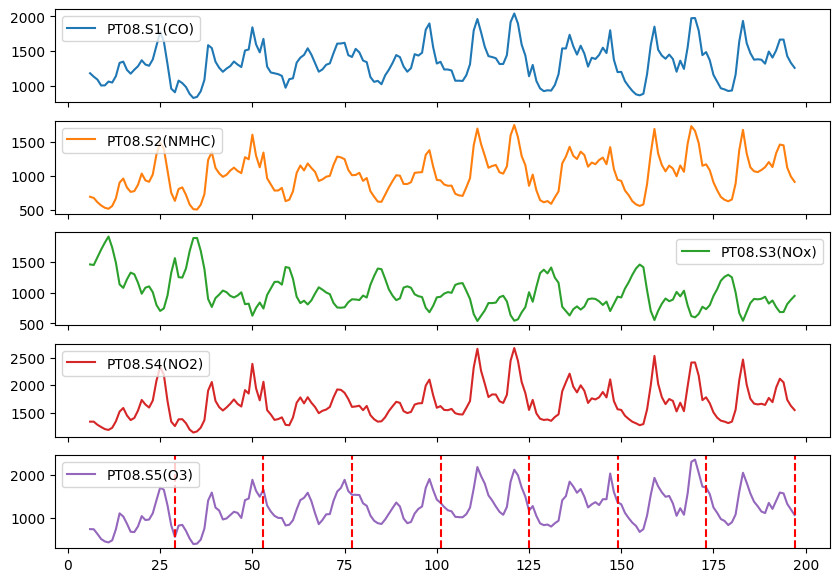

In [53]:
# first day of train set are the first 6 instances, then we have 24 instances per day
# discard the first day and consider the 8 days of train set and plot the colummns of X_train for these days
X_train[6 : 6 + 24*8].plot(subplots=True, figsize=(10, 7))
# write on x axis when a new day starts on each plot
for i in range(1, 9):
    plt.axvline(x = 6 + 24 * i - 1, color='r', linestyle='--')
plt.show()

In [54]:
# TODO: fare scaling considerando giorno per giorno, cioe fare scaling solo sulle 24 istanze di un giorno e non su tutto il train set

### Training Phase

### Evaluation

## One-step ahead Model